In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from tqdm import tqdm
import scipy
import pandas as pd
import datetime

from collections import OrderedDict    # For recording the model specification 

import statsmodels.tools.numdiff as numdiff       # For numeric hessian
import scipy.linalg                    # For matrix inversion

import pylogit as pl                   # For choice model estimation
from pylogit import nested_logit as nl # For nested logit convenience funcs
from xlogit import MixedLogit, MultinomialLogit
import pickle

In [3]:
df = pd.read_csv("data/data_2022_new.csv", index_col=0)
df["classement"] = df["classement"].replace(['DA', 'NP', '0', 'A ', 'G ', 'D4', 'D3', 'R8', 'D5', 'D2', 'D8', 'D7', 'H8', 'D1', 'D6',
       'D9', 'G4', 'T ', 'G3', 'D ', 'G7'], 10).astype(int)
df.head()

C:\Users\raves\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (110,112,113) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,nom,numPmu,age,sexe,race,statut,oeilleres,proprietaire,entraineur,driver,...,meanPerf,medianPerf,modePerf,recordAbs,gain,placeCorde,avisEntraineur,tauxReclamation,commentaireApresCourse_texte,commentaireApresCourse_source
0,FOU DE QUESNY,1,7,HONGRES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,J.P. GUERANGER,J.P. GUERANGER,https://www.letrot.com/stats/fiche-homme/i-jub...,...,-0.811765,0.0,0.0,0.416667,45440,NaN,NaN,NaN,NaN,NaN
1,ESPRIT D'OEILLET,2,8,HONGRES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,Mme B. DEMOULIN,G. LAUREYS,https://www.letrot.com/stats/fiche-homme/b-dem...,...,-1.929412,-1.5,0.4,1.000000,55566,NaN,NaN,NaN,NaN,NaN
2,FRICHTI,3,7,HONGRES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,J. VANMEERBECK,J. VANMEERBECK,https://www.letrot.com/stats/fiche-homme/s-lab...,...,-0.847059,-0.5,1.0,-0.583333,59080,NaN,NaN,NaN,NaN,NaN
3,GRANDE ET BELLE,4,6,FEMELLES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,M. MALINGE,P.Y. VERVA,https://www.letrot.com/stats/fiche-homme/th-le...,...,-0.752941,-0.5,1.2,0.250000,66220,NaN,NaN,NaN,NaN,NaN
4,FOR EVER MENCOURT,5,7,FEMELLES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,Ecurie Laurent VERVA,L. VERVA,https://www.letrot.com/stats/fiche-homme/y-des...,...,0.188235,-0.5,1.0,0.000000,66375,NaN,NaN,NaN,NaN,NaN


In [380]:
feat = df.loc[:]

feat["lifepercwin"] = feat["nombreVictoires"] / feat["nombreCourses"]
feat["winPrace"] = feat["gainsParticipant_gainsCarriere"] / feat["nombreCourses"]
feat["newDist"] = abs(feat["last_race_dist"] - feat["dist"]) > 150

feat["publicProbaOfWinning"] = 1 / feat["dernierRapportDirect_rapport"]

feat.fillna(0,inplace=True)

feat.replace([np.inf, -np.inf], 0, inplace=True)

feat["win"] = feat["classement"] == 1

feat["available"] = 1

feat["classement"] = feat["classement"].replace(0,10)
feat["win"] = feat["win"].replace(False,0)
feat["win"] = feat["win"].replace(True,1)

feat["newDist"] = feat["newDist"].astype(int)

feat = feat.set_index(["id", df.groupby("id").cumcount()])
index = pd.MultiIndex.from_product(feat.index.levels, names=feat.index.names)
feat = feat.reindex(index, fill_value=0).reset_index(level=1, drop=True).reset_index()

nindex = len(df.groupby("id")) * list(range(1,feat.groupby("id").cumcount().max()+2))

feat = feat.assign(num=nindex)

feat = feat.groupby("id").filter(lambda x: x.win.sum() == 1)
feat["chid"] = feat["id"].astype(str) + "_1"

76896

In [381]:
n_explo = 2

nfeat = feat.iloc[:18*len(feat.groupby("id"))//2].copy()

train = nfeat.copy()
print(len(train.groupby("chid")))
for i in range(2,n_explo+2):
    cfeat = nfeat.copy()

    cfeat["win"] = 0
    cfeat.loc[cfeat["classement"].isin( list(range(1,i)) ), ~cfeat.columns.isin(["id","num"])] = 0
    cfeat.loc[cfeat["classement"] == i, "win"] = 1
    cfeat["chid"] = cfeat["id"].astype(str) + f"_{i}"
    
    train = pd.concat([train, cfeat])
    print(len(train.groupby("chid")))
    
train = train.sort_values(by=["id", "chid", "num"])

1072
2144
3216


In [382]:
n_course = len(nfeat.groupby("id"))

# train = nfeat.loc[:].iloc[:18 * ( 2 * len(nfeat.groupby("chid"))//3)]
train = train.groupby("chid").filter(lambda x: x.win.sum() == 1)
test = feat.loc[:].iloc[18 * len(feat.groupby("id")) // 2:]

In [383]:
print(len(train.groupby("chid")),len(test.groupby("chid")))

3205 1072


In [12]:
list(train)

['id',
 'nom',
 'numPmu',
 'age',
 'sexe',
 'race',
 'statut',
 'oeilleres',
 'proprietaire',
 'entraineur',
 'driver',
 'driverChange',
 'indicateurInedit',
 'musique',
 'nombreCourses',
 'nombreVictoires',
 'nombrePlaces',
 'nombrePlacesSecond',
 'nombrePlacesTroisieme',
 'nomPere',
 'nomMere',
 'ordreArrivee',
 'jumentPleine',
 'engagement',
 'supplement',
 'handicapDistance',
 'poidsConditionMonteChange',
 'tempsObtenu',
 'reductionKilometrique',
 'urlCasaque',
 'eleveur',
 'allure',
 'robe_code',
 'robe_libelleCourt',
 'robe_libelleLong',
 'gainsParticipant_gainsCarriere',
 'gainsParticipant_gainsVictoires',
 'gainsParticipant_gainsPlace',
 'gainsParticipant_gainsAnneeEnCours',
 'gainsParticipant_gainsAnneePrecedente',
 'dernierRapportDirect_typePari',
 'dernierRapportDirect_rapport',
 'dernierRapportDirect_typeRapport',
 'dernierRapportDirect_indicateurTendance',
 'dernierRapportDirect_nombreIndicateurTendance',
 'dernierRapportDirect_dateRapport',
 'dernierRapportDirect_permutat

In [7]:
model = pickle.load(open('models/model_rapport.pickle', 'rb'))

EOFError: Ran out of input

In [384]:
model = MultinomialLogit()

In [385]:
features = ['num','dist','lifepercwin','winPrace','formeVictoire','formePlace','nbArriveMusic','lastPerf','meanPerf','medianPerf',
'modePerf','recordAbs','txReussiteCouple','nb3emeCouple','nb2emeCouple','nbVictoiresCouple','nbCourseCouple','rentree','last_race_dist',
'tpsLastRace','timeSinceRecord','minReduction','maxReduction','medianReduction','meanReduction','newDist','changementCategorie',
'distToPreferedDist','prefered_dist','jockeyHabitude','nbDiscalifieMusic','nbVictoireMusic','nbPlaceMusic','fer',
'firstTimeFer','gainsParticipant_gainsCarriere']
features_bac = ["fer","maxReduction_z","num","meanReduction_z","medianPerf_z","medianReduction_z","nbVictoiresTrainer_z","modePerf_z","nb2emeTandem_z","nb2emeCouple_z","newDist","timeBehindBestInRace_z","timeBehindBestMeanInRace_z","recordAbs_z","nbDiscalifieMusic_z","nbVictoireMusic","nbPlaceMusic","nombrePlacesSecond","nombrePlacesTroisieme_z","gainsParticipant_gainsAnneePrecedente_z","gainsParticipant_gainsVictoires_z","txReussiteTandem_z","lifepercwin","gainsParticipant_gainsAnneeEnCours_z", "txReussiteCouple_z", "nbCourseCouple_z","nbVictoiresCouple_z", "txReussiteTrainer_z", "timeSinceRecord_z", "nombreVictoires_z"]
# features = ["fer","nbDiscalifieMusic","timeBehindBestInRace_z","timeBehindBestMeanInRace_z","nombrePlacesSecond","nombrePlacesTroisieme_z", "txReussiteCouple_z", "nbCourseCouple_z","nbVictoiresCouple_z", "txReussiteTrainer_z", "timeSinceRecord_z", "nombreVictoires_z"]


# randvars = {name:"n" for name in features}
randvars={"nbDiscalifieMusic":"u"}

In [386]:
train[features]

,num,dist,lifepercwin,winPrace,formeVictoire,formePlace,nbArriveMusic,lastPerf,meanPerf,medianPerf,...,changementCategorie,distToPreferedDist,prefered_dist,jockeyHabitude,nbDiscalifieMusic,nbVictoireMusic,nbPlaceMusic,fer,firstTimeFer,gainsParticipant_gainsCarriere
0,1,2700,0.409091,4.504293,0,0,-1.6,-0.727273,-1.196854,-0.666667,...,0,-0.854795,0.723898,1,2.000000,-1.0,-0.8,3,0,-4.003816
1,2,2700,0.409091,1.604153,1,1,-0.6,0.545455,-0.341958,-0.333333,...,0,2.432877,-2.060325,1,-1.333333,2.0,0.0,1,1,-1.425914
2,3,2700,0.000000,0.000000,0,1,0.0,0.000000,0.132984,0.000000,...,0,0.000000,0.000000,0,0.666667,-1.0,0.4,3,0,-0.589825
3,4,2700,0.461538,0.743243,0,0,-1.0,-0.727273,0.940386,1.000000,...,0,2.410959,-2.041763,0,0.000000,-1.0,-0.8,3,0,-0.585586
4,5,2700,0.000000,-0.735404,0,0,-0.4,0.909091,0.390810,0.666667,...,0,0.252055,-0.213457,0,2.000000,-1.0,0.0,3,0,-0.430843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19309,14,2825,0.188889,0.000000,0,0,-1.0,0.516129,1.206024,1.076923,...,1,-0.359932,0.359932,0,-0.250000,-1.0,-1.0,0,0,0.000000
19310,15,0,0.000000,0.000000,0,0,0.0,0.000000,0.000000,0.000000,...,0,0.000000,0.000000,0,0.000000,0.0,0.0,0,0,0.000000
19311,16,0,0.000000,0.000000,0,0,0.0,0.000000,0.000000,0.000000,...,0,0.000000,0.000000,0,0.000000,0.0,0.0,0,0,0.000000
19312,17,0,0.000000,0.000000,0,0,0.0,0.000000,0.000000,0.000000,...,0,0.000000,0.000000,0,0.000000,0.0,0.0,0,0,0.000000


In [387]:
model.fit(X = train[features], y = train["win"], varnames=features, ids=train["chid"],alts=train["num"],avail=train["available"],maxiter=10000,tol_opts={"gtol": 1e-10})
model.summary()

Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 14
    Function evaluations: 16
Estimation time= 3.7 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
num                     0.0044103     0.0056462     0.7811041         0.588    
dist                   -0.0103693     0.0030700    -3.3776035       0.00268 ** 
lifepercwin             0.0014957     0.0033945     0.4406312         0.724    
winPrace                0.0027361     0.0032636     0.8383577         0.561    
formeVictoire           0.3035740     0.0741244     4.0954655      0.000185 ***
formePlace              0.1755032     0.0597773     2.9359488        0.0108 *  
nbArriveMusic           0.0610568     0.0338759     1.8023700         0.157    
lastPerf               -0.0314312     0.0282652    -

In [135]:
train["probaModel"]

0        0.051777
1        0.062339
2        0.064297
3        0.035236
4        0.040338
           ...   
19309    0.052860
19310    0.000000
19311    0.000000
19312    0.000000
19313    0.000000
Name: probaModel, Length: 57690, dtype: float64

In [359]:
choice_estimate, proba_estimate = model.predict(X=train[features], varnames=features, ids=train["chid"], alts=train["num"],avail=train["available"],return_proba=True)
train["probaModel"] = proba_estimate.flatten()
train["probaModel"].replace(-np.inf,0, inplace=True)
train["probaModel"].fillna(0, inplace=True)

In [175]:
np.ones((len(train["win"]),1))

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [361]:
null_model = MultinomialLogit()
null_model.fit(X=train[["publicProbaOfWinning"]], y=train["win"], varnames=["num"], ids=train["chid"],alts=train["num"],avail=train["available"])
null_model.summary()

Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 5
    Function evaluations: 6
Estimation time= 0.0 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
num                     5.7396237     0.1389933    41.2942620     8.13e-298 ***
---------------------------------------------------------------------------
Significance:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log-Likelihood= -7150.137
AIC= 14302.273
BIC= 14308.346


In [360]:
second_model = MixedLogit()
second_model.fit(X=train[["probaModel", "publicProbaOfWinning"]],y=train["win"],varnames=["probaModel", "publicProbaOfWinning"], ids=train["chid"],alts=train["num"],avail=train["available"], randvars={"probaModel": "u"})
second_model.summary()

GPU processing enabled.
Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 6
    Function evaluations: 14
Estimation time= 1.2 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
probaModel              2.4469378     0.3274368     7.4730081      7.51e-13 ***
publicProbaOfWinnin     5.0803308     0.1702821    29.8347981     1.91e-171 ***
sd.probaModel           4.7239334     1.5359300     3.0756176       0.00708 ** 
---------------------------------------------------------------------------
Significance:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log-Likelihood= -7118.295
AIC= 14242.590
BIC= 14260.807


In [371]:
choice, proba = model.predict(X=test[features], varnames=features, ids=test["id"], alts=test["num"],avail=test["available"],return_proba=True)
test["probaModel"] = proba_model.flatten()
test["probaModel"].replace(-np.inf,0, inplace=True)
test["probaModel"].fillna(0, inplace=True)

In [363]:
choice, proba = second_model.predict(X=test[["probaModel", "publicProbaOfWinning"]],varnames=["probaModel", "publicProbaOfWinning"], ids=test["chid"],alts=test["num"],avail=test["available"], return_proba=True)

GPU processing enabled.


In [338]:
sum(choice == choice_model) / len(choice_model)

0.43656716417910446

In [364]:
winners_odd = test.loc[test["win"] == 1]["dernierRapportDirect_rapport"].to_numpy()
winners = test.loc[test["win"] == 1]["num"].to_numpy()

odds = test["dernierRapportDirect_rapport"].to_numpy().reshape(-1,18)

def kelly(p,b):
    return p - (1-p)/b

def expe(p,b):
    e = p*(b+1)
    m_e = np.argmax( e )
    return m_e, e[m_e]

In [365]:
test["proba"] = proba.flatten()

In [366]:
nb_chevaux = []
proba_moy_theo = []
proba_moy = []
rapport_moyen = []
classe = [0,0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.4,1.]
inter = []
for i,j in zip(classe, classe[1:]):
    inter.append(f"{i} à {j}")
    echantillon = proba.flatten()[(i < proba.flatten()) & (proba.flatten() <= j)]
    
    rapport = test[(i < test["proba"] ) & (test["proba"] <=j )]["dernierRapportDirect_rapport"].to_numpy()
    rapport_moyen.append(np.mean(rapport))
    nb_chevaux.append( len(echantillon ))
    proba_moy.append( np.mean(echantillon) )
    proba_moy_theo.append(np.mean([i,j]))
rapport_moy_theo = 1/np.array(proba_moy_theo)

In [367]:
pd.DataFrame({"PROBA": inter, "Proba moyenne théorique": proba_moy_theo, "Rapport théorique": rapport_moy_theo, "Proba moyenne": proba_moy,"Rapport moyen": rapport_moyen, "NB Chevaux": nb_chevaux})

,PROBA,Proba moyenne théorique,Rapport théorique,Proba moyenne,Rapport moyen,NB Chevaux
0,0 à 0.01,0.0050,200.000000,0.008362,85.200000,5
1,0.01 à 0.025,0.0175,57.142857,0.019607,64.108511,423
2,0.025 à 0.05,0.0375,26.666667,0.039548,54.175749,6412
3,0.05 à 0.1,0.0750,13.333333,0.067173,12.644780,4435
4,0.1 à 0.15,0.1250,8.000000,0.121558,5.290874,1030
5,0.15 à 0.2,0.1750,5.714286,0.172187,3.978252,492
6,0.2 à 0.25,0.2250,4.444444,0.223200,3.314644,239
7,0.25 à 0.3,0.2750,3.636364,0.272924,2.981879,149
8,0.3 à 0.4,0.3500,2.857143,0.345707,2.590196,204
9,0.4 à 1.0,0.7000,1.428571,0.555285,2.256855,248


In [368]:
accu = np.sum(winners == choice)/len(choice)
print(f"Win%: {round(accu, 4) * 100}%, nbet: {len(choice)}")

Win%: 32.09%, nbet: 1072


In [369]:
test.loc[test["id"] == race_id[0]][["id", "num","numCoursePMU", "classement","date","dernierRapportDirect_rapport"]]

,id,num,numCoursePMU,classement,date,dernierRapportDirect_rapport
21078,2022063053056,1,R3C6,10,2022-06-30,112.0
21079,2022063053056,2,R3C6,5,2022-06-30,46.0
21080,2022063053056,3,R3C6,10,2022-06-30,88.0
21081,2022063053056,4,R3C6,7,2022-06-30,3.7
21082,2022063053056,5,R3C6,10,2022-06-30,18.0
21083,2022063053056,6,R3C6,3,2022-06-30,5.4
21084,2022063053056,7,R3C6,10,2022-06-30,22.0
21085,2022063053056,8,R3C6,6,2022-06-30,33.0
21086,2022063053056,9,R3C6,1,2022-06-30,10.0
21087,2022063053056,10,R3C6,10,2022-06-30,8.9


        mean   max  min  median
0  16.193333  40.0  3.3    15.0
Win%: 0.08287292817679558, nwin: 15,nbet: 181
Gain de 61€, gain moyen de 0.47%


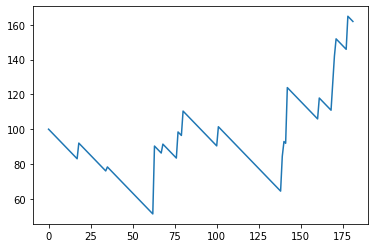

In [372]:
from statsmodels.stats.descriptivestats import describe
win = 0
tot = 0
odds_winned = []

money = 100
evo = [money]


sorted_proba = np.argsort(proba)

race_id = []

for i in range(len(choice)):
    cheval,Er = expe(proba[i], odds[i])
    place_best = sorted_proba[i, -3:]
    
#     best_place,Er = expe(proba[i], odds[i])
#     print(best_place,Er, place_best[best_place])
#     best_expe = place_best[best_place]
    
    er = proba[i, :] * odds[i, :]
    er_sorted = np.argsort(er)
    er_pos = er_sorted[ np.sort(er) > 0  ]
    
    prob = proba[i, er_pos]
    
    filtre = er_pos[prob > 0.1]
   
    
    advantage = er - 1
    
    p = proba[i, choice[i] - 1]
    choice_expe = proba[i, choice[i] - 1] * odds[i][choice[i] - 1]
#     print(proba[i, choice[i] - 1] * odds[i][choice[i] - 1] - (1-proba[i, choice[i] - 1]))

    if choice_expe > 2 and p > 0.1:
#         wagger = kelly(proba[i][choice[i] - 1],odds[i][ choice[i] - 1])
#         print(winners[i], er_pos + 1)
        if choice[i] == winners[i]:
            race_id.append( test["id"].unique()[i] )
            win += 1
#             print(f"Win le {winners[i]}|{choice[i]} a gagné  avec une cote de {odds[i][winners[i] - 1]}")
            money += odds[i][ winners[i] - 1]
            odds_winned.append(odds[i][winners[i] - 1])
        money -= 1
        evo.append(money)
        tot+=1
        
print(describe(odds_winned, stats=["max", "min", "mean", "median"]).T)
print(f"Win%: {win/tot}, nwin: {win},nbet: {tot}")
print(f"Gain de {int(money-100)}€, gain moyen de {round(np.mean((np.array(evo[1:]) - np.array(evo[:-1]))/ np.array(evo[:-1]))*100,2)}%")
plt.plot(evo)
# plt.yscale("log")

0.16417910447761194

In [150]:
np.mean((np.array(evo[1:]) - np.array(evo[:-1]))/ np.array(evo[:-1]))

0.0009021730021085995

In [119]:
test[["num", "nom","numCoursePMU", "dernierRapportDirect_rapport"]]

,num,nom,numCoursePMU,dernierRapportDirect_rapport
115561,2,GLORIA D'AVE,R11C2,18.0
115562,3,GOODMORNING CHARLY,R11C2,5.5
115563,4,GATINKA,R11C2,25.0
115564,5,GALIA SOTHO,R11C2,3.3
115565,6,GROVE CITY,R11C2,13.0
...,...,...,...,...
130446,12,HARLEY GEMA,R1C9,3.8
130447,13,HAUTE COUTURE,R1C9,13.0
130448,14,HORCHATA,R1C9,8.6
130449,15,HELIA DU GARABIN,R1C9,8.2


In [121]:
len(test["id"].unique())

1054

In [124]:
len(choice)

1566

In [426]:
today = pd.read_csv("today.csv", index_col=0)
today.index = np.arange(len(today))
today.drop_duplicates(subset=["id", "num"], inplace=True)
today.head()

,id,num,nom,numCoursePMU,date,url,meanReduction,medianReduction,maxReduction,minReduction,...,txReussiteTrainer_z,nbCourseTandem_z,nbVictoiresTandem_z,nb2emeTandem_z,nb3emeTandem_z,txReussiteTandem_z,nbVictoiresDriver_z,nb2emeDriver_z,nb3emeDriver_z,txReussiteDriver_z
0,2022112144132,1,JAFLOSA AR CARAC,R8C2,2022-11-21,https://www.letrot.com/stats/fiche-cheval/jafl...,782.200000,789.0,794,758,...,-0.906532,-0.919804,-0.559255,-0.733674,-0.760413,0.000000,1.601313,1.435983,1.201541,1.049781
1,2022112144132,2,JOSIE DE MIENNAIS,R8C2,2022-11-21,https://www.letrot.com/stats/fiche-cheval/josi...,779.750000,779.5,784,776,...,-0.607675,-0.724101,-1.091878,0.146735,-1.022624,-0.662589,-0.779903,-0.719448,-0.942852,-0.699854
2,2022112144132,3,JALISCA DES AMBRES,R8C2,2022-11-21,https://www.letrot.com/stats/fiche-cheval/jali...,769.000000,770.0,780,756,...,0.388514,2.080976,2.370175,2.201022,2.386123,0.414118,-0.342982,-0.457301,-0.296130,0.524891
3,2022112144132,4,JOY DU RIF,R8C2,2022-11-21,https://www.letrot.com/stats/fiche-cheval/joy-...,774.666667,769.5,804,766,...,1.683559,-1.050273,-0.559255,-0.733674,-0.498202,1.408002,-0.211906,0.008738,0.452705,0.174964
4,2022112144132,5,JAG LUCAXELO,R8C2,2022-11-21,https://www.letrot.com/stats/fiche-cheval/jag-...,764.600000,763.0,786,745,...,-1.006150,0.906757,-0.559255,0.440204,0.812855,-0.745413,-0.736211,-0.690321,-0.704586,-0.699854


In [420]:
groups = today[['id',
            'meanPerf',
            'medianPerf',
            'modePerf',
            'recordAbs',
            'nbDiscalifieMusic',
            'nbVictoireMusic',
            'nbPlaceMusic',
            'nbArrivé',
            'nombreCourses',
            'nombreVictoires',
            'nombrePlaces',
            'nombrePlacesSecond',
            'nombrePlacesTroisieme',
            'gainsParticipant_gainsCarriere',
            'gainsParticipant_gainsVictoires',
            'gainsParticipant_gainsPlace',
            'gainsParticipant_gainsAnneeEnCours',
            'gainsParticipant_gainsAnneePrecedente',
            'nbCourseCouple',
            'nbVictoiresCouple',
            'nb2emeCouple',
            'nb3emeCouple',
            'txReussiteCouple',
            'nbCourseTrainer',
            'timeBehindBestInRace',
            'timeBehindBestMeanInRace',
            'dernierRapportDirect_rapport',
            'dernierRapportReference_rapport',
            'meanReduction',
            'medianReduction',
            'maxReduction',
            'minReduction',
            'timeSinceRecord',
            'nbVictoiresTrainer',
            'nb2emeTrainer',
            'nb3emeTrainer',
            'txReussiteTrainer',
            'nbCourseTandem',
            'nbVictoiresTandem',
            'nb2emeTandem',
            'nb3emeTandem',
            'txReussiteTandem',
            'nbCourseDriver',
            'nbVictoiresDriver',
            'nb2emeDriver',
            'nb3emeDriver',
            'txReussiteDriver']].groupby("id")
mean, std = groups.transform("mean"), groups.transform("std")
normalized = (today[mean.columns] - mean) / std

In [421]:
today = today.join(normalized, lsuffix='', rsuffix='_z')

In [427]:
today = today.set_index(["id", today.groupby("id").cumcount()])
index = pd.MultiIndex.from_product(today.index.levels, names=today.index.names)
today = today.reindex(index, fill_value=0).reset_index(level=1, drop=True).reset_index()

nindex = len(today.groupby("id")) * list(range(1,today.groupby("id").cumcount().max()+2))

today = today.assign(num=nindex)

In [ ]:
today.fillna(0, inplace=True)

In [508]:
course = today[today["id"] == 2022112175003]
choice, proba = model.predict(X=course[features], varnames=features, ids=course["id"], alts=course["num"],return_proba=True)
sorted_prob = np.argsort(proba)
print(choice, sorted_prob + 1)
print("BET?:", proba[0][sorted_prob[0,-1]] - proba[0][sorted_prob[0,-2]])
print(proba)

GPU processing enabled.
[13] [[18 17 15 10 14  2  8  5  1 12  9 11  4 16  3  7  6 13]]
BET?: 0.09451432598493653
[[4.62952203e-02 1.56253574e-02 7.86837611e-02 6.74041419e-02
  3.35621491e-02 1.30016453e-01 1.02615551e-01 3.12753306e-02
  4.90970462e-02 9.43041568e-03 6.70380100e-02 4.87963451e-02
  2.24530779e-01 1.32252281e-02 8.95309910e-03 7.33991569e-02
  2.60335168e-05 2.59216192e-05]]


array([[17, 16, 15,  9,  1,  5, 12,  8, 14,  4,  2,  0,  3, 10,  6, 13,
        11,  7]], dtype=int64)

In [479]:
today[today["id"] == 2022112144138]

,id,num,nom,numCoursePMU,date,url,meanReduction,medianReduction,maxReduction,minReduction,...,txReussiteTrainer_z,nbCourseTandem_z,nbVictoiresTandem_z,nb2emeTandem_z,nb3emeTandem_z,txReussiteTandem_z,nbVictoiresDriver_z,nb2emeDriver_z,nb3emeDriver_z,txReussiteDriver_z
90,2022112144138,1,FABULEUX PIYA,R8C8,2022-11-21,https://www.letrot.com/stats/fiche-cheval/fabu...,763.405405,760.0,832,730,...,0.178783,-0.511346,0.077339,-0.595399,-0.413771,0.235968,1.051719,0.980345,1.219590,1.406469
91,2022112144138,2,EQUIN DE GRAVEL,R8C8,2022-11-21,https://www.letrot.com/stats/fiche-cheval/equi...,789.406250,782.0,850,746,...,-1.519658,-0.646384,-0.751294,-0.734946,-0.565150,-0.729357,-0.684128,-0.832622,-0.852150,-1.735643
92,2022112144138,3,DESIRA SWIFT,R8C8,2022-11-21,https://www.letrot.com/stats/fiche-cheval/desi...,771.194444,770.5,828,745,...,1.251483,-0.862446,-0.751294,-0.734946,-0.716530,-0.930466,-0.020422,0.543890,0.828696,0.957596
93,2022112144138,4,DIVA DU CHERISAY,R8C8,2022-11-21,https://www.letrot.com/stats/fiche-cheval/diva...,764.255319,765.0,799,744,...,0.625742,0.947070,1.568879,2.474629,0.797265,0.437078,-0.326748,-0.026859,-0.422166,1.406469
94,2022112144138,5,DAKOTA DE PLOMB,R8C8,2022-11-21,https://www.letrot.com/stats/fiche-cheval/dako...,762.823529,762.5,789,740,...,-0.804525,-0.038711,-0.419841,0.102334,-0.565150,-0.367360,-0.633073,-0.631181,-0.852150,-0.725678
95,2022112144138,6,ELIOS DU LIBEROT,R8C8,2022-11-21,https://www.letrot.com/stats/fiche-cheval/elio...,777.571429,778.0,801,762,...,-1.072700,0.514947,-0.254114,-0.316306,0.191747,-0.488025,-0.505438,-0.664755,-0.578524,-0.725678
96,2022112144138,7,ECRIN DU LAYON,R8C8,2022-11-21,https://www.letrot.com/stats/fiche-cheval/ecri...,767.071429,764.0,812,737,...,-0.268175,-0.484338,-0.751294,-0.455853,-0.716530,-0.689135,-0.658601,-0.765475,-0.852150,-0.950115
97,2022112144138,8,EXPERT DELTA,R8C8,2022-11-21,https://www.letrot.com/stats/fiche-cheval/expe...,760.125000,757.0,821,736,...,-0.536350,2.662059,2.728966,1.916442,2.916579,0.034859,-0.045949,0.040288,0.320533,0.172068
98,2022112144138,9,CEPAGE DES ULMES,R8C8,2022-11-21,https://www.letrot.com/stats/fiche-cheval/cepa...,761.959184,755.0,879,721,...,0.357567,-0.767919,-0.751294,-0.595399,-0.716530,-0.447803,-0.684128,-0.799049,-0.891239,-0.950115
99,2022112144138,10,DIESIS DU GOUTIER,R8C8,2022-11-21,https://www.letrot.com/stats/fiche-cheval/dies...,762.592593,760.0,820,724,...,-0.804525,1.149628,0.243066,0.800068,0.797265,-0.206472,-0.530965,-0.429740,-0.500345,-0.389023


In [454]:
today["id"].unique()

array([2022112144132, 2022112144133, 2022112144135, 2022112144136,
       2022112144137, 2022112144138, 2022112175001, 2022112175003],
      dtype=int64)

In [448]:
today[today["numCoursePMU"] == "R8C2"]

,id,num,nom,numCoursePMU,date,url,meanReduction,medianReduction,maxReduction,minReduction,...,txReussiteTrainer_z,nbCourseTandem_z,nbVictoiresTandem_z,nb2emeTandem_z,nb3emeTandem_z,txReussiteTandem_z,nbVictoiresDriver_z,nb2emeDriver_z,nb3emeDriver_z,txReussiteDriver_z
0,2022112144132,1,JAFLOSA AR CARAC,R8C2,2022-11-21,https://www.letrot.com/stats/fiche-cheval/jafl...,782.200000,789.0,794,758,...,-0.906532,-0.919804,-0.559255,-0.733674,-0.760413,0.000000,1.601313,1.435983,1.201541,1.049781
1,2022112144132,2,JOSIE DE MIENNAIS,R8C2,2022-11-21,https://www.letrot.com/stats/fiche-cheval/josi...,779.750000,779.5,784,776,...,-0.607675,-0.724101,-1.091878,0.146735,-1.022624,-0.662589,-0.779903,-0.719448,-0.942852,-0.699854
2,2022112144132,3,JALISCA DES AMBRES,R8C2,2022-11-21,https://www.letrot.com/stats/fiche-cheval/jali...,769.000000,770.0,780,756,...,0.388514,2.080976,2.370175,2.201022,2.386123,0.414118,-0.342982,-0.457301,-0.296130,0.524891
3,2022112144132,4,JOY DU RIF,R8C2,2022-11-21,https://www.letrot.com/stats/fiche-cheval/joy-...,774.666667,769.5,804,766,...,1.683559,-1.050273,-0.559255,-0.733674,-0.498202,1.408002,-0.211906,0.008738,0.452705,0.174964
4,2022112144132,5,JAG LUCAXELO,R8C2,2022-11-21,https://www.letrot.com/stats/fiche-cheval/jag-...,764.600000,763.0,786,745,...,-1.006150,0.906757,-0.559255,0.440204,0.812855,-0.745413,-0.736211,-0.690321,-0.704586,-0.699854
5,2022112144132,6,JADE HERINIERE,R8C2,2022-11-21,https://www.letrot.com/stats/fiche-cheval/jade...,784.285714,789.0,798,766,...,-0.707294,-0.756718,-0.026631,-0.146735,-0.235990,1.739297,0.705626,0.707797,0.895199,1.574672
6,2022112144132,7,JONGLEUSE ALTO,R8C2,2022-11-21,https://www.letrot.com/stats/fiche-cheval/jong...,775.600000,778.5,804,752,...,-1.205388,0.287031,-0.559255,-1.027144,-0.235990,-1.490826,-0.736211,-0.835958,-0.772662,-1.924599
7,2022112144132,8,JUMANJI SIBEY,R8C2,2022-11-21,https://www.letrot.com/stats/fiche-cheval/juma...,763.285714,765.0,779,745,...,0.786989,0.352265,0.505992,-0.440204,0.026221,-0.496942,-0.583289,-0.632066,-0.738624,0.174964
8,2022112144132,9,JOKER DES MOLLES,R8C2,2022-11-21,https://www.letrot.com/stats/fiche-cheval/joke...,752.900000,753.0,782,723,...,0.786989,0.450117,0.772304,1.027144,0.288432,0.331295,1.797927,1.902022,1.780187,0.349927
9,2022112144132,10,JOKE,R8C2,2022-11-21,https://www.letrot.com/stats/fiche-cheval/joke...,752.733333,748.0,789,722,...,0.786989,-0.626250,-0.292943,-0.733674,-0.760413,-0.496942,-0.714365,-0.719448,-0.874776,-0.524891


In [447]:
choice

array([10, 12, 11, 11, 10,  8, 11, 13], dtype=int64)

In [413]:
[*test2.groupby("id").cumcount()]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15]

In [38]:
# Create the model's specification dictionary and variable names dictionary
# NOTE: - Keys should be variables within the long format dataframe.
#         The sole exception to this is the "intercept" key.
#       - For the specification dictionary, the values should be lists
#         or lists of lists. Within a list, or within the inner-most
#         list should be the alternative ID's of the alternative whose
#         utility specification the explanatory variable is entering.




# features_bu = ["available","trainerIsDriver","txReussiteDriver_z","fer","nbArrivé_z","nb3emeTandem_z","nb3emeDriver_z","nb3emeCouple_z","nb2emeTandem_z","nb2emeCouple_z","newDist","timeBehindBestInRace_z","timeBehindBestMeanInRace_z","recordAbs","nbDiscalifieMusic","nbVictoireMusic","nbPlaceMusic","nombrePlacesSecond","nombrePlacesTroisieme_z","gainsParticipant_gainsAnneePrecedente_z","gainsParticipant_gainsVictoires_z","txReussiteTandem_z","winPrace","lifepercwin","gainsParticipant_gainsAnneeEnCours_z", "txReussiteCouple_z", "nbCourseCouple_z","nbVictoiresCouple_z", "txReussiteTrainer_z", "timeSinceRecord_z", "nombreVictoires_z"]
features = ["fer","nb2emeTandem_z","nb2emeCouple_z","newDist","timeBehindBestInRace_z","timeBehindBestMeanInRace_z","recordAbs","nbDiscalifieMusic","nbVictoireMusic","nbPlaceMusic","nombrePlacesSecond","nombrePlacesTroisieme_z","gainsParticipant_gainsAnneePrecedente_z","gainsParticipant_gainsVictoires_z","txReussiteTandem_z","lifepercwin","gainsParticipant_gainsAnneeEnCours_z", "txReussiteCouple_z", "nbCourseCouple_z","nbVictoiresCouple_z", "txReussiteTrainer_z", "timeSinceRecord_z", "nombreVictoires_z"]

example_specification = OrderedDict()
example_names = OrderedDict()

for col in features:
    example_specification[col] = [list(range(1,19))]
    example_names[col] = [col]

In [45]:
# Provide the module with the needed input arguments to create
# an instance of the MNL model class


example_mixed = pl.create_choice_model(data=train,
                                        alt_id_col="num",
                                        obs_id_col="id",
                                        choice_col="win",
                                        specification=example_specification,
                                        model_type="Mixed Logit",
                                        names=example_names,
                                        mixing_id_col="id",
                                        mixing_vars=features)

# Create the initial values for estimation.
# Note that we need one value for each beta
# coefficient and for each of the standard deviations
# that will now be estimated.

example_mixed.fit_mle(init_vals=np.zeros(2 * len(features)),
                      num_draws=500)

example_mixed.get_statsmodels_summary()

Log-likelihood at zero: -5,130.4099
Initial Log-likelihood: -5,130.4099


C:\Users\raves\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:548: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


KeyboardInterrupt: 

In [11]:
preds = example_mixed.predict(test, num_draws=100).reshape(-1,18)
preds_course = np.argmax(preds, axis=1) + 1
acu = sum(test.loc[test["win"] == 1]["num"] == preds_course) / len(preds_course)
print(acu)

0.2790960451977401


In [13]:
winners_odd = test.loc[test["win"] == 1]["dernierRapportDirect_rapport"].to_numpy()

In [71]:
winners_odd = test.loc[test["win"] == 1]["dernierRapportDirect_rapport"].to_numpy()

def kelly(p,b):
    return p - (1-p)/b

def expe(p,b):
    e = p*b - (1-p)
    m_e = np.argmax( p*b - (1-p) )
    return m_e, e[m_e]

In [106]:
winners = test.loc[test["win"] == 1]["num"].to_numpy()
odds = test["dernierRapportDirect_rapport"].to_numpy().reshape(-1,18)

sorted_preds = np.argsort(preds)

best_p = 0
best_er = 0

best_cap = 0



for p_tresh in np.linspace(0,0.2,40):
    for er_tresh in np.linspace(0,1.5,40):
        win = 0
        tot = 0
    #     odds_winned = []

        cap = 100
    #     evo = [cap]


        for i in range(len(preds)):
            preds1 = sorted_preds[i][-1]
            preds2 = sorted_preds[i][-2]
            cheval,Er = expe(preds[i], odds[i])
            if odds[i][cheval] > 0 and Er > er_tresh and preds[i][cheval] > p_tresh:
                wagger = kelly(preds[i][cheval],odds[i][cheval]) * cap
                if winners[i] == cheval + 1:
                    win += 1
                    cap += wagger * odds[i][cheval]
    #                 odds_winned.append(odds[i][cheval])
                cap -= wagger
    #             evo.append(cap)
                tot+=1

        if cap > best_cap:
            best_cap = cap
            best_p = p_tresh
            best_er = er_tresh
print(f"Best cap: {best_cap} for params: {best_p=}, {best_er=}")

Best cap: 460.79357800673836 for params: best_p=0.015384615384615385, best_er=0.9230769230769231


                 0
mean     21.361538
max     173.000000
min       4.400000
median    8.000000
Win%: 0.13829787234042554, nbet: 94


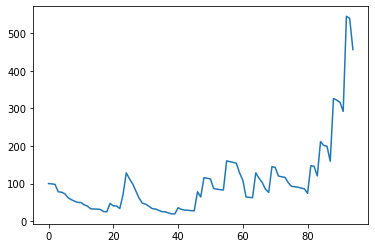

In [108]:
from statsmodels.stats.descriptivestats import describe
win = 0
tot = 0
odds_winned = []

cap = 100
evo = [cap]


winners_odd = test.loc[test["win"] == 1]["dernierRapportDirect_rapport"].to_numpy()

def kelly(p,b):
    return p - (1-p)/b

def expe(p,b):
    e = p*b - (1-p)
    m_e = np.argmax( p*b - (1-p) )
    return m_e, e[m_e]

for i in range(len(preds)):
    preds1 = sorted_preds[i][-1]
    preds2 = sorted_preds[i][-2]
    cheval,Er = expe(preds[i], odds[i])
    if odds[i][cheval] > 0 and Er > 0.92 and preds[i][cheval] > 0.015:
        wagger = kelly(preds[i][cheval],odds[i][cheval]) * cap
        if winners[i] == cheval + 1:
            win += 1
            cap += wagger * odds[i][cheval]
            odds_winned.append(odds[i][cheval])
        cap -= wagger
        evo.append(cap)
        tot+=1
print(describe(odds_winned, stats=["max", "min", "mean", "median"]))
print(f"Win%: {win/tot}, nbet: {tot}")
plt.plot(evo)

In [89]:
mean_odds = np.mean(odds_winned)
median_odds = np.median(odds_winned)
print(mean_odds, median_odds, np.max(odds_winned), np.min(odds_winned))

5.328688524590164 4.8 15.0 1.4


In [99]:
test

,id,num,nom,numCoursePMU,classement,date,meanReduction,medianReduction,maxReduction,minReduction,...,txReussiteTandem_z,nbVictoiresDriver_z,nb2emeDriver_z,nb3emeDriver_z,txReussiteDriver_z,lifepercwin,winPrace,newDist,win,available
15948,2021072250083,1,HIPPO DE BEAUM,R6C3,10,2021-07-22,783.571429,781.0,822,765,...,-1.681135,-0.714631,-0.735320,-0.873203,-2.227441,0.000000,19583.333333,0,0,1
15949,2021072250083,2,HACH DES CAPELLES,R6C3,8,2021-07-22,801.000000,802.0,805,794,...,-0.898975,-0.697110,-0.718105,-0.873203,-0.928100,0.100000,99700.000000,1,0,1
15950,2021072250083,3,HOCHE,R6C3,1,2021-07-22,777.000000,777.5,784,769,...,0.665343,1.475570,1.055025,0.948539,0.725606,0.000000,70000.000000,0,1,1
15951,2021072250083,4,HADOL DU CHATELET,R6C3,10,2021-07-22,783.142857,790.0,795,761,...,1.660819,0.249057,0.504149,1.164271,0.371240,0.066667,48866.666667,1,0,1
15952,2021072250083,5,HAUGAIN,R6C3,6,2021-07-22,781.500000,784.5,798,759,...,-0.970081,-0.714631,-0.735320,-0.801293,-1.046222,0.100000,116700.000000,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31891,2021123175009,14,HORCHATA,R1C9,7,2021-12-31,766.727273,765.0,807,733,...,1.153314,-0.046198,-0.047263,0.186222,-0.025928,0.142857,133761.904762,1,0,1
31892,2021123175009,15,HELIA DU GARABIN,R1C9,8,2021-12-31,769.500000,766.5,805,741,...,-0.314991,-0.847823,-0.962680,-1.116216,-0.440775,0.307692,210000.000000,1,0,1
31893,2021123175009,16,HELEN DES OUBEAUX,R1C9,4,2021-12-31,774.500000,766.5,811,750,...,-0.672146,0.620089,1.040624,0.560896,0.527201,0.000000,50875.000000,1,0,1
31894,2021123175009,17,0,0,10,0,0.000000,0.0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0


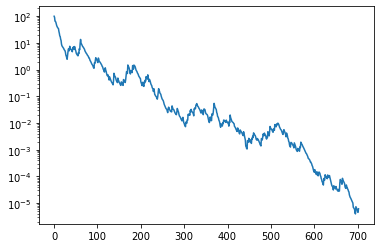

In [90]:
plt.plot(evo)
plt.yscale("log")

In [3]:
import pickle
example_mixed = pickle.load(open("mixedlogit1.pkl", "rb"))